In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom as dicom
import numpy as np
import skimage
import math

# Verification of intensity modulated radiotherapy (IMRT) plan.
## Author: Pavlin Tsonev

## I. Introduction.

In the near past in radiotherapy there was only one planning technique but with the development of radiotherapy technologies, producers succeeded to add $MLC$ (multileaf collimator) between the radioactive source and patient [1] which allows us to modify the form of the treatment field as we want. In my last project (Monte Carlo simulation of teletherapy machine ($^{60}$Co machine).) I demonstrate with simulation what will happen if we add $MLC$ to Cobalt-60 machine and showed that the result is not so good because of the big penumbra. For this reason in radiotherapy we already use linear accelerator which gives us significantly smaller penumbra and makes it possible to add $MLC$. Thats great but the $MLC$ is made from $120$ leafs (two banks with $60$ leafs) and when we optimize and calculate radiotherapy plan we actually optimize the motion of each leaf during the treatment. But every leaf have different mechanical characteristics also we have to take into account that the machine rotates and irradiates simultaneously, leafs are heavy which means that it is possible to have influence of gravity. For these reasons we can't be sure that machine will produce exactly the same dose distribution as calculated one from treatment planning system. So every treatment plan needs to be verified before starting with treatment of the patient. Verification of treatment plan actually is comparison between dose distributions produced by machine and from planning system [2]. To get dose distribution from machine we have to execute the treatment plan and to measure the output. From comparison of these two distributions we will get quantitative information on the performance of the treatment plan.

## II. Plan verification.

### 1. Preparing images for comparison.

To measure the dose distribution produced by the machine we irradiate detector which is called $EPID$ (electronic portal image device) [1]. This detector accumulate absorbed dose and return us $DICOM$ file with image and information about patient (I changed information about patient before start working with these files) and fields. This is the measurment from machine which we will compare with the result from treatment planning system. But we have to take into account that the sensitivity of the detector is not a constant so to calibrate it we irradiate the detector with $0.5Gy$ with simple square field with size $10x10cm$ and will use the measured output as normalization. File which contains this information is called $"normalization.dcm"$ and is in the directory of every patient.

First let's read the $DICOM$ files, show the images and plot just one row from them:

In [3]:
def reading_dicom_images(planning, machine, normalization, patient):
    
    PATH_PLANNING_SYSTEM_FILES = f"Data/{patient}/planning_system/{planning}"
    PATH_MACHINE_FILES = f"Data/{patient}/machine/{machine}"
    PATH_NORMALIZATION_FILES = f"Data/{patient}/machine/{normalization}"
    
    field_planning = dicom.dcmread(PATH_PLANNING_SYSTEM_FILES) #DICOM file from planning system
    field_machine =  dicom.dcmread(PATH_MACHINE_FILES) #DICOM file from machine
    normalization = dicom.dcmread(PATH_NORMALIZATION_FILES) #normalization DICOM file
    
    #show images and plot one row from them
    plt.imshow(field_planning.pixel_array, cmap="gray")
    plt.title("Image from planning system")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(field_planning.pixel_array[250])
    plt.title("Row from image from planning system")
    plt.xlabel("x")
    plt.grid()
    plt.show()
    plt.imshow(field_machine.pixel_array, cmap="gray")
    plt.title("Image from machine")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(field_machine.pixel_array[350])
    plt.title("Row from image from machine")
    plt.xlabel("x")
    plt.grid()
    plt.show()
    plt.imshow(normalization.pixel_array, cmap="gray")
    plt.title("Normalization image")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(normalization.pixel_array[350])
    plt.title("Row from normalization image")
    plt.xlabel("x")
    plt.grid()
    plt.show()

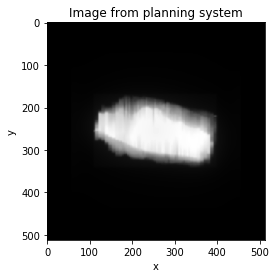

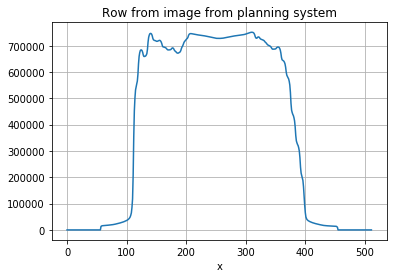

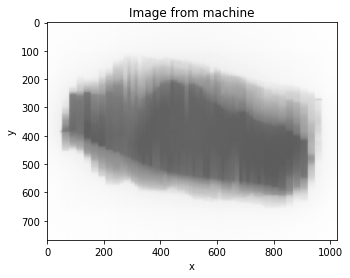

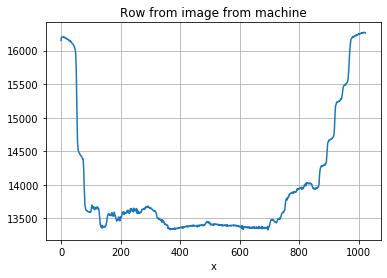

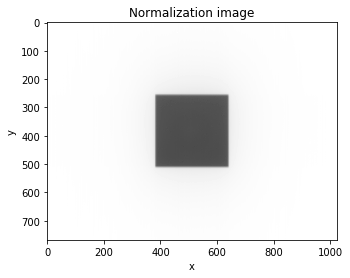

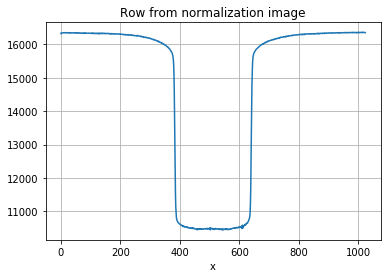

In [4]:
reading_dicom_images("arc1_planning.dcm", "arc1_machine.dcm", "normalization.dcm", "Patient1")

From these images we can see several things:

1. Images from machine are "reversed" to the image from planning system which is because of the specification of the detector.
2. Values and units are different for images from planning system and from machine.
3. The images are with different shapes and sizes.

Let's fix the first and the second issue.

In $DICOM$ file from planning system there is $"Dose Grid Scaling"$ [3] factor which when we multiply by the values of the pixels in the image will return us values in $Gy$. In $DICOM$ files from machine there is $"Rescale Intercept"$ [3] and $"Rescale Slope"$ [3] factors to get the values of the pixels in $Gy$ we have to use the following formula:

$$Output = m . SV + b \space \space (1) \space [3]$$

where $m$ is the $"Rescale Slope"$ factor, $SV$ is the stored values and $b$ is the $"Rescale Intercept"$ factor.

Except these transformations we have to normalize the result for dose distribution from machine. To do this we will take the mean value of the area from normalization field which was irradiated with $0.5Gy$ and will divide $0.5$ to this result. This will give us normalization factor for the dose then we can multiply this factor to values of the pixels from $DICOM$ image from machine and to get corrected image.

As we already say size of the normalization field is $10x10cm$ and is in the center of detector (which means in the center of the image) this means that this area is from center of the image to $50mm$ away. To measure $50mm$ we will use $"Image Plane Pixel Spacing"$ [3] from $DICOM$ file which is the distance between centers of two neighboring pixels in $mm$.

With code below we apply this transformations to $DICOM$ files, show the images and plot again the same rows:

In [5]:
def changing_values_of_dicom_images(planning, machine, normalization, patient):
    
    PATH_PLANNING_SYSTEM_FILES = f"Data/{patient}/planning_system/{planning}"
    PATH_MACHINE_FILES = f"Data/{patient}/machine/{machine}"
    PATH_NORMALIZATION_FILES = f"Data/{patient}/machine/{normalization}"
    
    field_planning = dicom.dcmread(PATH_PLANNING_SYSTEM_FILES) #DICOM file from planning system
    #changing values and units of image from planning system
    field_planning_transformed = field_planning.pixel_array * field_planning.DoseGridScaling 
    
    field_machine =  dicom.dcmread(PATH_MACHINE_FILES) #DICOM file from machine
    #changing values and units of image from machine
    field_machine_transformed = field_machine.RescaleIntercept + field_machine.pixel_array * field_machine.RescaleSlope
    
    normalization = dicom.dcmread(PATH_NORMALIZATION_FILES) #normalization DICOM file
    #changing values and units of normalization image from machiine
    normalization_transformed = normalization.RescaleIntercept + normalization.pixel_array * normalization.RescaleSlope
    
    #determining irradiated area from normalization image
    x1 = math.ceil((normalization.pixel_array.shape[0] / 2) - (50 / normalization.ImagePlanePixelSpacing[0]))
    x2 = math.floor((normalization.pixel_array.shape[0] / 2) + (50 / normalization.ImagePlanePixelSpacing[0]))
    y1 = math.ceil((normalization.pixel_array.shape[1] / 2) - (50 / normalization.ImagePlanePixelSpacing[1]))
    y2 = math.floor((normalization.pixel_array.shape[1] / 2) + (50 / normalization.ImagePlanePixelSpacing[1]))
    
    mean_normalization = normalization_transformed[x1:x2, y1:y2].mean()
    
    #calculating normalization factor
    norm_factor = 0.5 / mean_normalization
    
    #applying the normalization factor to image from machine
    field_machine_transformed *= norm_factor

    #show images and plot one row from them
    plt.imshow(field_planning_transformed, cmap="gray")
    plt.title("Transformed image from planning system")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(field_planning_transformed[250])
    plt.title("Row from transformed image from planning system")
    plt.xlabel("x")
    plt.ylabel("D [Gy]")
    plt.grid()
    plt.show()
    plt.imshow(field_machine_transformed, cmap="gray")
    plt.title("Transformed image from machine")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(field_machine_transformed[350])
    plt.title("Row from transformed image from machine")
    plt.xlabel("x")
    plt.ylabel("D [Gy]")
    plt.grid()
    plt.show()
    plt.imshow(normalization_transformed, cmap="gray")
    plt.title("Transformed normalization image")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(normalization_transformed[350])
    plt.title("Row from transformed normalization image")
    plt.xlabel("x")
    plt.ylabel("D [Gy]")
    plt.grid()
    plt.show()

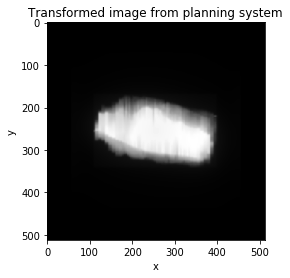

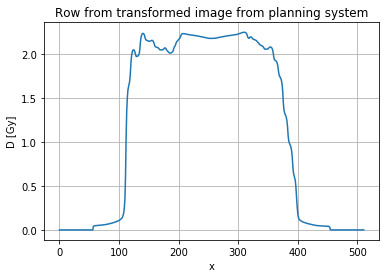

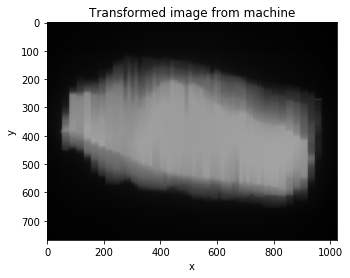

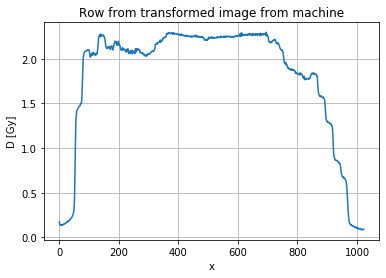

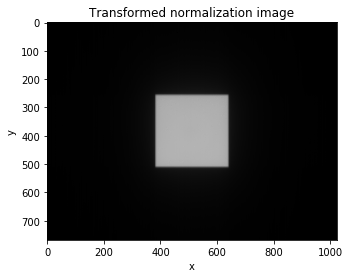

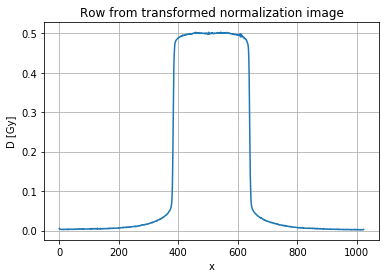

In [6]:
changing_values_of_dicom_images("arc1_planning.dcm", "arc1_machine.dcm", "normalization.dcm", "Patient1")

After we fixed issues with units and values of the pixels we can move to the size and shape of the images.

For this purpose we will use $"Image Plane Pixel Spacing"$ from $DICOM$ image from machine to measure size of the whole image in $mm$. After this we can use $"Pixel Spacing"$ [3] which is distance between center of two neighboring pixels in $mm$ from $DICOM$ image from planning system and to determine the same area in $mm$ as image from machine. After this we will rescale the image from planning system to same size like the image from machine.

In [7]:
def transforming_dicom_images(planning, machine, normalization, patient):
    
    PATH_PLANNING_SYSTEM_FILES = f"Data/{patient}/planning_system/{planning}"
    PATH_MACHINE_FILES = f"Data/{patient}/machine/{machine}"
    PATH_NORMALIZATION_FILES = f"Data/{patient}/machine/{normalization}"
    
    field_planning = dicom.dcmread(PATH_PLANNING_SYSTEM_FILES) #DICOM file from planning system
    #changing values and units of image from planning system
    field_planning_transformed = field_planning.pixel_array * field_planning.DoseGridScaling 
    
    field_machine =  dicom.dcmread(PATH_MACHINE_FILES) #DICOM file from machine
    #changing values and units of image from machine
    field_machine_transformed = field_machine.RescaleIntercept + field_machine.pixel_array * field_machine.RescaleSlope
    
    normalization = dicom.dcmread(PATH_NORMALIZATION_FILES) #normalization DICOM file
    #changing values and units of normalization image from machiine
    normalization_transformed = normalization.RescaleIntercept + normalization.pixel_array * normalization.RescaleSlope
    
    #determining irradiated area from normalization image
    x1 = math.ceil((normalization.pixel_array.shape[0] / 2) - (50 / normalization.ImagePlanePixelSpacing[0]))
    x2 = math.floor((normalization.pixel_array.shape[0] / 2) + (50 / normalization.ImagePlanePixelSpacing[0]))
    y1 = math.ceil((normalization.pixel_array.shape[1] / 2) - (50 / normalization.ImagePlanePixelSpacing[1]))
    y2 = math.floor((normalization.pixel_array.shape[1] / 2) + (50 / normalization.ImagePlanePixelSpacing[1]))
    
    mean_normalization = normalization_transformed[x1:x2, y1:y2].mean()
    
    #calculating normalization factor
    norm_factor = 0.5 / mean_normalization
    
    #applying the normalization factor to image from machine
    field_machine_transformed *= norm_factor
    
    #calculating size of image from machine in [mm]
    hight = field_machine.ImagePlanePixelSpacing[0] * field_machine.pixel_array.shape[0]
    width = field_machine.ImagePlanePixelSpacing[1] * field_machine.pixel_array.shape[1]
    
    #determining same area from image from planning system as from machine
    x1_planning = math.ceil((field_planning_transformed.shape[0] / 2) - (hight / (2 * field_planning.PixelSpacing[0])))
    x2_planning = math.floor((field_planning_transformed.shape[0] / 2) + (hight / (2 * field_planning.PixelSpacing[0])))
    y1_planning = math.ceil((field_planning_transformed.shape[1] / 2) - (width / (2 * field_planning.PixelSpacing[1])))
    y2_planning = math.floor((field_planning_transformed.shape[1] / 2) + (width / (2 * field_planning.PixelSpacing[1])))
    
    field_planning_transformed = field_planning_transformed[x1_planning:x2_planning, y1_planning:y2_planning]
    
    #rescale image from planning system to have same size in pixels as image from machine
    field_planning_transformed = skimage.transform.rescale(field_planning_transformed, field_machine_transformed.shape[0] / field_planning_transformed.shape[0], multichannel=False)
    
    return [field_planning_transformed, field_machine_transformed, field_machine.ImagePlanePixelSpacing]

In [8]:
def plotting_images(fields):
    plt.imshow(fields[0], cmap="gray")
    plt.title("Final image from planning system")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.imshow(fields[1], cmap="gray")
    plt.title("Final image from machine")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    plt.plot(fields[1][400], c = "red")
    plt.plot(fields[0][400], c = "green")
    plt.title("Single row from final images")
    plt.xlabel("x")
    plt.ylabel("D [Gy]")
    plt.legend(["machine", "planning system"])
    plt.grid()
    plt.show()
    plt.plot(fields[1][400] - fields[0][400])
    plt.title("Difference between images")
    plt.xlabel("x")
    plt.ylabel("D [Gy]")
    plt.grid()
    plt.show()
    
    print("Shape of DICOM image from planning system :", fields[0].shape)
    print("Shape of DICOM image from machine :", fields[1].shape)

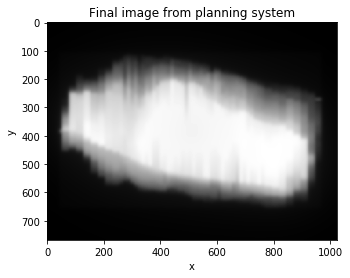

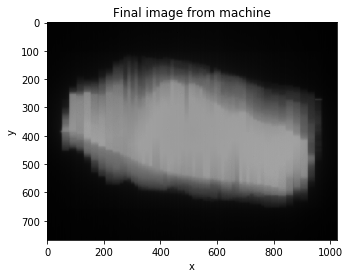

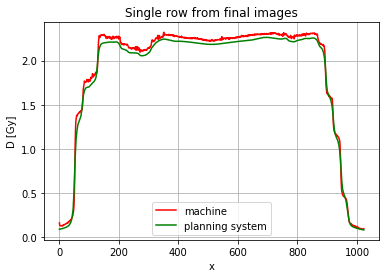

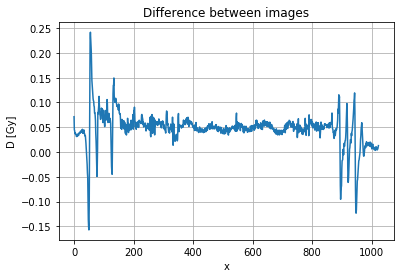

Shape of DICOM image from planning system : (768, 1024)
Shape of DICOM image from machine : (768, 1024)


In [9]:
plotting_images(transforming_dicom_images("arc1_planning.dcm", "arc1_machine.dcm", "normalization.dcm", "Patient1"))

We can see that image from machine is darker than image from planning system. This is because there is a broken pixel in detector which detect more dose than he recieves and change the gray scale. But this pixel is only one and will not affect the final result so we can leave it unchanged.

### 2. Comparison of images.

From physics we know two main things first it is impossible to measure something with absolute accuracy and second it is impossible to have exactly the same result in practice as our calculations. For this reason we will say that values for the pixels of both images are the same if the dose difference ($DD$) is less than $3\%$ (this is the most used value for this criteria in world practice [2,4,5]) of the value for current pixel in image from machine. But this is not enought to compare images correctly because every leaf has physical size which is the reason for not so smooth change of the dose also there is a very small gap between leafs and we can't do nothing for this. We can see from plotted graphics above that in regions with hight dose gradient seems like the dose distributions completely match but difference in dose is bigger than in regions with small gradient. Reason for this is that in these regions very small spatial displacements lead to big dose difference[2,4]. For this reason we have to use one more criteria which is called "distance to agreement" ($DTA$)[2,4]. This criteria is the distance between a measured point and the nearest point in the calculated dose distribution that exhibits the same dose. In world practice most used value for this criteria is $DTA = 3mm$ [2,4,5].

In our comparison of the images we will use both criteria to get quantitative value for every measured point. We can represent a $DTA$ criteria as a disk in $2D$ array and $DD$ as vertical line from $-3\%$ to $3\%$ [2] from value of the measured point as it is shown on the figure bellow.

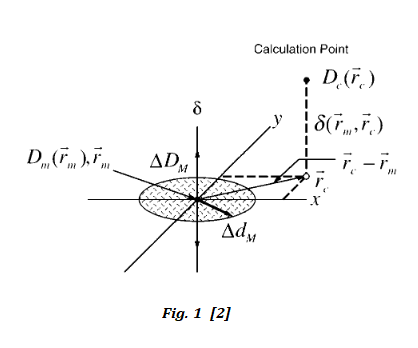

Where $ \Delta D_M $ is dose difference criteria, $ \Delta d_M $ is distance to agreement criteria, $ \delta (r_m , r_c) = D_c (r_c) - D_m (r_m) $ is the difference between dose values on the calculated and measured distribution and $ r_c - r_m $ is distance between calculated and measured point.

When we apply both criteria at the same time we can represent the surface of acceptance criteria as ellipsoid with center measured point as it is shown on next figure.

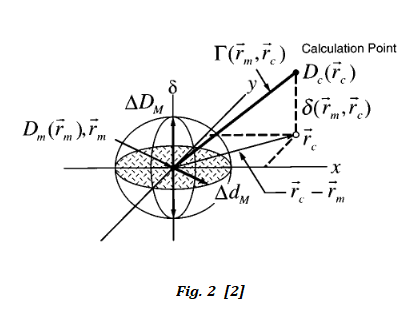

If any point from calculated distribution intersect the ellipsoid we can say that this point passes the criteria [2,4]. Surface of this ellipsoid can be represented mathematicaly with the following equation: 

$$1 = \sqrt {{r^2 (r_m , r) \over \Delta {d^2}_M} + {\delta ^2 (r_m , r) \over \Delta D^2 _M}} \space (2) \space [2]$$

Equation which is presented above will be used as quality index for each point in comparison of the images. This index has the following form:

$$\gamma = min \{ \Gamma (r_m , r_c) \} \forall \{ r_c \} \space (3) \space [2]$$

$$ \Gamma (r_m , r_c) = \sqrt {{r^2 (r_m , r_c) \over \Delta {d^2}_M} + {\delta ^2 (r_m , r_c) \over \Delta D^2 _M}} \space (4) \space [2]$$

This quality index is called gamma index and according to equations above pass-fail criteria become as follows: $ \gamma (r_m) \leq 1 $ - calculation pass and for $ \gamma (r_m) \gt 1 $ - calculation fails [2,4].

We need to add padding to image from planning system because in comparison of the images we will use distance to agreement criteria which means that for pixels near to the edges of the image we don't have values to calculate the gamma index. Width of this padding will be equal to distance to agreement criteria and values for these pixels in padding will be slightly larger than maximum value in image because we want to be sure that gamma index for these pixels will not be the minimum value and they will not affect determining part of the pixels which fails acceptance test.

To determine width of the padding in number of pixels we will use $ImagePlanePixelSpacing$ from $DICOM$ file from machine. 

But from both images we have information about dose only for discrete points which is represented as pixels. Pixels which centers pass distance to agreement criteria are shown in red, central pixel is in green and the pixels part of which fall into the circle that outlines the distance to agreement criteria area but their centers are outside are in blue.

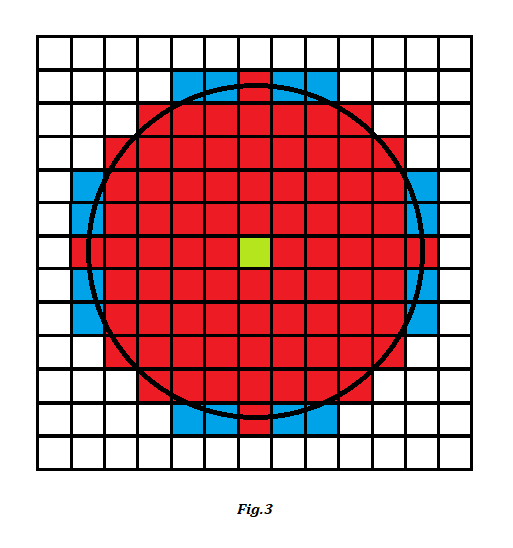

To be sure that we will not miss information from these "blue" parts inside the circle we will round up number of pixels to the bigger integer when we calculate value for distance to agreement criteria in number of pixels and will add one more pixel to this value. To determine this area in our code we will use $Pythagorean \space theorem$. Also we have to add one more pixel to padding around the image.

This pass-fail test is great but only for regions with dose significantly different than $0Gy$. For regions which is behind the jaws of the linear accelerator (low dose regions) we can't use this test because values for accumulated dose in image from machine there are very small but different than $0Gy$ while the values for same regions from image from planning system are equal to $0Gy$ and if we apply this criteria there is no chance for these points to pass above acceptance test. The reason for these small but different than $0Gy$ values is that there is background radiation, radiation which passes trought the jaws and scattered radiation and our planning system doesn't take these factors into account. So we have to use different criteria there. It's appropriate to use only dose difference criteria because there is no high dose gradient subregions but the value of this criteria here will be constant for all pixels and will be equal to $3\%$ from the mean dose of the $10\%$ of pixels from whole image with highest values. And low dose regions will be defined as regions with dose less than $5\%$ from the mean dose of the same $10\%$ of pixels from whole image with highest dose.

Below is presented the code for calculating the gamma index, image comparison as described and calculating percent of points which fails the acceptance test.

In [10]:
def comparing_dicom_images(planning, machine, normalization, patient, dd_criteria, dta_criteria):
    
    #taking transformed images and patient
    field_planning_transformed, field_machine_transformed, pixel_spacing = transforming_dicom_images(planning, 
                                                                                      machine, 
                                                                                      normalization, 
                                                                                      patient)
    
    #calculating distance to agreement criteria in pixels for both axes
    dta_in_number_of_pixels_x = math.ceil(dta_criteria / pixel_spacing[0]) + 1
    dta_in_number_of_pixels_y = math.ceil(dta_criteria / pixel_spacing[1]) + 1
    
    #calculating width of padding in pixels for both axes
    padding_width_lr = dta_in_number_of_pixels_x
    padding_width_tb = dta_in_number_of_pixels_y
    
    #create padding
    field_planning_transformed = np.pad(field_planning_transformed, 
                                        ((padding_width_tb, padding_width_tb),(padding_width_lr, padding_width_lr)), 
                                        mode='constant', 
                                        constant_values=field_planning_transformed.max() + 1)
    
    #create gamma matrix which will be applyed to image from planning system
    gamma_matrix = np.zeros((dta_in_number_of_pixels_x * 2 + 1, dta_in_number_of_pixels_y * 2 + 1))
    for i in range(gamma_matrix.shape[0]):
        for j in range(gamma_matrix.shape[1]):
            if np.sqrt(((abs(i - dta_in_number_of_pixels_x))**2 + (abs(j - dta_in_number_of_pixels_y))**2) * pixel_spacing[0] * pixel_spacing[1]) <= dta_in_number_of_pixels_x * pixel_spacing[0]:
                gamma_matrix[i,j] += ((abs(i - dta_in_number_of_pixels_x))**2 + (abs(j - dta_in_number_of_pixels_y))**2) * pixel_spacing[0] * pixel_spacing[1] / dta_criteria ** 2
    
    #counter for points with gamma index great than 1
    counter_gamma_gt_1 = 0
    
    #determine value which will separate low dose area
    gt_dose = 0.05 * field_machine_transformed[field_machine_transformed > 0.9 * field_machine_transformed.max()].mean()
    
    #create criteria for low dose region
    low_dose_criteria = dd_criteria * field_machine_transformed[field_machine_transformed > 0.9 * field_machine_transformed.max()].mean() / 100
    
    for row in range(field_machine_transformed.shape[0]):
        for column in range(field_machine_transformed.shape[1]):
            
            #apply gamma matrix to image from planning system for non-low dose regions, calculate gamma index and count points failing the criteria
            if field_machine_transformed[row, column] > gt_dose:
                part = field_planning_transformed[row : row + dta_in_number_of_pixels_y * 2 + 1 , column : column + dta_in_number_of_pixels_x * 2 + 1]
                dose_difference_matrix = abs(part - field_machine_transformed[row, column])
                dose_difference_matrix_to_criteria = (dose_difference_matrix ) ** 2 / (dd_criteria * field_machine_transformed[row, column] / 100) ** 2
                gamma_index = np.sqrt(gamma_matrix + dose_difference_matrix_to_criteria).min()
                if gamma_index > 1:
                    counter_gamma_gt_1 += 1
                    
            #apply criteria for low dose regions and count points failing criteria
            else:
                gamma_index = field_machine_transformed[row, column] - field_planning_transformed[row + padding_width_tb, column + padding_width_lr] / low_dose_criteria
                if gamma_index > 1:
                    counter_gamma_gt_1 += 1
                
    gamma_failing = round(counter_gamma_gt_1 * 100 / field_machine_transformed.size, 2)
            
    return gamma_failing

In [11]:
comparing_dicom_images("arc2_planning.dcm", "arc2_machine.dcm", "normalization.dcm", "Patient1", 3, 3)

0.43

Since we already have program which calculate percent of tested points which fail the acceptance criteria we can move to comparison of results from our program with results from commercial software. Results are from $EPIQA$ software and are in files with names $"result\_from\_commercial\_software.html"$ in folder of every patient. In next part is presented table with results from both programs.

### 3. Presenting obtained results from our program and results from commercial software.

Bellow is the code for presenting results from our program and from commercial software as data frame:

In [12]:
all_fields_planning = ("arc1_planning.dcm", "arc2_planning.dcm", "arc1_planning.dcm", "arc2_planning.dcm", "arc1_planning.dcm", "arc2_planning.dcm", "med_planning.dcm", "lat_planning.dcm")
all_fields_machine = ("arc1_machine.dcm", "arc2_machine.dcm", "arc1_machine.dcm", "arc2_machine.dcm", "arc1_machine.dcm", "arc2_machine.dcm", "med_machine.dcm", "lat_machine.dcm")
patients = ("Patient1", "Patient1", "Patient2", "Patient2", "Patient3", "Patient3", "Patient4", "Patient4")

In [13]:
our_results = []
commercial_software_results = []
for i in range(len(patients)):
    our_results.append(comparing_dicom_images(all_fields_planning[i], 
                                              all_fields_machine[i], 
                                              "normalization.dcm", 
                                              patients[i], 3, 3))
    
    commercial_software_results.append(pd.read_html(f"Data/{patients[i]}/result_from_commercial_software.html")[8]["g>1 [%]"][i % 2])
    
pd.DataFrame({"Patient": patients, 
              "Field": all_fields_machine, 
              "Result from our program [%]": our_results, 
              "Result from commercial software [%]": commercial_software_results})

,Patient,Field,Result from our program [%],Result from commercial software [%]
0,Patient1,arc1_machine.dcm,0.68,0.49
1,Patient1,arc2_machine.dcm,0.43,0.22
2,Patient2,arc1_machine.dcm,1.98,2.93
3,Patient2,arc2_machine.dcm,1.32,1.22
4,Patient3,arc1_machine.dcm,0.20,0.53
5,Patient3,arc2_machine.dcm,0.44,0.71
6,Patient4,med_machine.dcm,1.55,1.35
7,Patient4,lat_machine.dcm,2.13,1.11


From presented results in table above we can see that they are not equal but they are quite close. This is very good and expected result because there is a lot of softwares and all of them use same algorithm core (gamma index) for comparison of the images but different software treat low dose areas in different ways and because points in these areas are sometimes more than half of all the points all these softwares will give us different results which is as in our case - quite close.

## III. Conclusion.

In conclusion we can say that we get pretty good calculations for percent of points which fail the acceptance test. $EPIQA$ software doesn't test all the points in the image to run faster but still gives us good enought rates for verification of the treatment plans in our everyday work in hospital. To get more accurate estimate of this value we can use other softwares which need phantom. These phantoms are very expensive and it takes time for positioning while $EPID$ is part of the linear accelerator and verification of the treatment plans with $EPIQA$ is much faster and quite good. In practice to accept standard treatment plan and to start treat the patient with this plan we need more than $95\%$ image mathing which means less than $5\%$ of points to fail the acceptance test [5]. In our case we get less than $1\%$ difference between results which is less than our acceptance criteria for the treatment plan. It is possible our results to be more accurate than these from $EPIQA$ but to check this we need to compare them with results from other more accurate software and with measurements of the dose profile made with phantom.

## IV. References.

1. Radiation Oncology Physics: A handbook for teacher and students. E.B. Podgorsak.
2. “A technique for the quantitative evaluation of dose distributions” - Daniel A. Low, a) William B. Harms, Sasa Mutic, and James A. Purdy - Mallinckrodt Institute of Radiology, Division of Radiation Oncology, 510 South Kingshighway Blvd. - St. Louis, Missouri 63110 – 1998
3. https://dicom.innolitics.com/ciods
4. Tolerance limits and methodologies for IMRT measurment-based verification QA: Recomendations of AAPM Task Group No.218 – Moyed Miften, Aarthur Olch, Dimitris Mihailidis,Jean, Moran, Todd Pawlicki, Andrea Molineu, Harold Li, Krishni Wijesooriya, Jie Shi, Ping Xia, Nikos Papanikolaou, Daniel A. Low
5. Journal of the ICRU - Report 83, Volume 10 No 1 2010